# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import spacy
import re
import nltk

# import string

import sklearn
import neattext as nt
import neattext.functions as nfx
import pandas as pd
import tensorflow as tf
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import pickle

from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# Libraries for general purpose
# Text cleaning
import string
import emoji
from nltk.stem import WordNetLemmatizer, PorterStemmer
# Data preprocessing
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler


2024-04-06 21:31:59.706144: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 21:31:59.710232: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 21:31:59.765034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 21:32:00.818136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-04-06 21:32:02.584084: I external/loc

In [2]:
# from google.colab import drive

# drive_path = "/content/augmented_dataset.csv"
# df = pd.read_csv(drive_path)

df = pd.read_csv('augmented_dataset.csv')

# Exploratory data analysis

In [3]:
df.sample(10)

,tweet_text,cyberbullying_type
12367,@N7Kopper @InnominateSterd @nitramy To be fair...,gender
63441,iodine hope that iodine 'll beryllium successf...,gender
36921,You are wrong. The reason for school shootings...,age
44645,You 2 dumb ugly nigger name Wayne Positive tra...,ethnicity
32332,Im really proud to say I’ve never been the gir...,age
25044,"I think we really need to talk about these, to...",other_cyberbullying
6099,"#flashback pas SD di-bully terus, dipalak sama...",not_cyberbullying
84299,iodine would go to school if this Washington t...,age
95052,are YOU dense THE ice_cream truck song “ bash ...,ethnicity
4594,RT @BlizzHeroes: Proof that anyone can find lo...,not_cyberbullying


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95384 entries, 0 to 95383
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          95384 non-null  object
 1   cyberbullying_type  95384 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


**Dataset columns and features**

In [5]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [6]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

**Remove duplicate tweets**

In [7]:
df.duplicated().sum()

174

In [8]:
df = df[~df.duplicated()]
df.duplicated().sum()

0

**Femove null tweets if any**

In [9]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

# Data Visualisation

**Check if all classes are balanced**

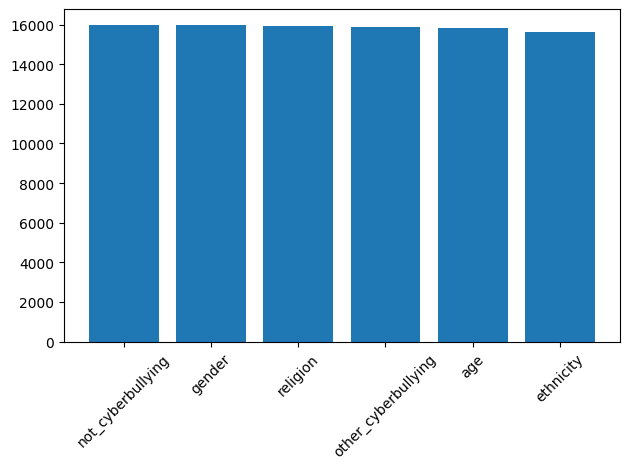

cyberbullying_type
religion               15989
age                    15975
ethnicity              15907
gender                 15880
not_cyberbullying      15846
other_cyberbullying    15613
Name: count, dtype: int64


In [10]:
plt.bar(df['cyberbullying_type'].unique(), df['cyberbullying_type'].value_counts())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(df['cyberbullying_type'].value_counts())

**Find out most common hate words**

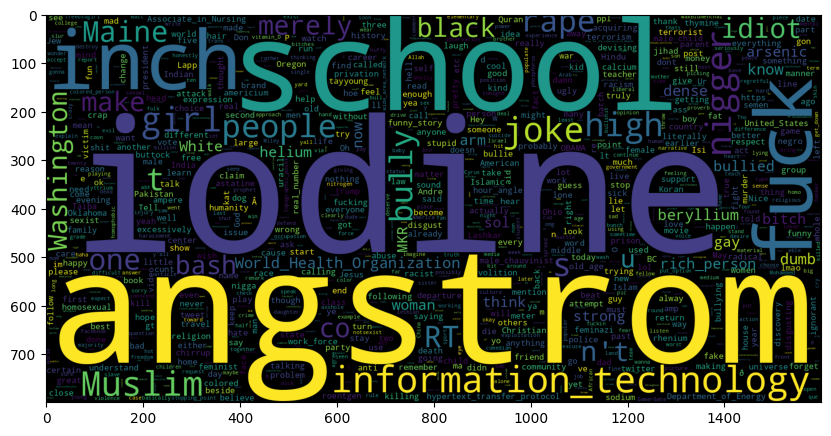

In [11]:
from wordcloud import WordCloud
plt.figure(figsize= (10,10))
wc = WordCloud(max_words=1000, width= 1600, height= 800, collocations= False).generate(' '.join(df['tweet_text']))
plt.imshow(wc)

# Data Processing

**Use neattext and NLTK for filtering stopwords, hashtags, emoji,remove URL**

In [12]:
df.sample(5)

,tweet_text,cyberbullying_type
34936,To the girl that bullied me in high school who...,age
89260,information_technology angstrom joke uracil de...,ethnicity
46986,"@tayyoung_: FUCK OBAMA, dumb ass nigger&lt;&lt...",ethnicity
92938,@ StripForMe_ @ MLGJurpi @ SamTheAM bash n't c...,ethnicity
39059,Ya the girl who bullied and stalked me in high...,age


In [13]:
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_hashtags)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_userhandles)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_multiple_spaces)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_stopwords)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_urls)

In [14]:
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_html_tags)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_emojis)
df['tweet_text'] = df['tweet_text'].apply(nfx.fix_contractions)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_special_characters)
df['tweet_text'] = df['tweet_text'].apply(nfx.remove_puncts)

**Convert all letters to lowercase**

In [15]:
df['tweet_text'] = df['tweet_text'].str.lower()

**Cleaned dataset**

In [16]:
df.sample(5)

,tweet_text,cyberbullying_type
76748,autodimming display nice certain battery life...,other_cyberbullying
38886,fucking burnley like little shit school hiding...,age
27082,jackets actual jackets fake pockets,other_cyberbullying
6376,question is daesh murderers innocent civilians...,not_cyberbullying
23380,idiotic construction ure totally desperate bab...,religion


# Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['cyberbullying_type'] = labelencoder.fit_transform(df['cyberbullying_type'])

In [18]:

# 0 - age
# 1 - ethnicity
# 2 - gender
# 3 - not_cyberbullying
# 4 - other_cyberbullying
# 5 - religion


In [19]:
df.sample(5)

,tweet_text,cyberbullying_type
81286,informationtechnology mind school bullycumming...,0
33401,shitty ex bf girl bullied high school toxic ex...,0
74250,coopatropp randi randiio,4
61065,karma s angstrom bitch right kat mkr mkr2015,2
58163,glock bisexual female trait manner information...,2


# NON DL ALGORITHMS
* SVM
* Naive bayes
* Random Forests


**Train Test Split**

In [20]:
seed_value = 300
X = df['tweet_text']
y = df['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [21]:
# Transforming the data using TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features= 500000)
vectoriser.fit(X_train)
print("No. of feature words: ",len(vectoriser.get_feature_names_out()))

No. of feature words:  489677


In [22]:
# transforming the data
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [23]:
X_train

<60934x489677 sparse matrix of type '<class 'numpy.float64'>'
	with 1580330 stored elements in Compressed Sparse Row format>

In [24]:
X_test

<19042x489677 sparse matrix of type '<class 'numpy.float64'>'
	with 380624 stored elements in Compressed Sparse Row format>

In [25]:
y_train

12062    2
93463    1
18373    5
20524    5
44287    1
        ..
29563    4
85470    0
26688    4
1917     3
62090    2
Name: cyberbullying_type, Length: 60934, dtype: int64

In [26]:
y_test

49043    3
88438    1
15404    2
70333    5
28238    4
        ..
57016    2
79660    0
27424    4
81808    0
35011    0
Name: cyberbullying_type, Length: 19042, dtype: int64

# Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [28]:
accuracy = nb.score(X_test, y_test)
print(accuracy)

0.7725028883520638


In [29]:
from sklearn.metrics import classification_report
nb_pred = nb.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.73      0.99      0.84      3195
           1       0.86      0.94      0.90      3181
           2       0.83      0.86      0.84      3176
           3       0.68      0.39      0.50      3169
           4       0.66      0.46      0.54      3123
           5       0.79      0.99      0.88      3198

    accuracy                           0.77     19042
   macro avg       0.76      0.77      0.75     19042
weighted avg       0.76      0.77      0.75     19042



In [30]:
with open('naivebayes.pkl', 'wb') as file:
    pickle.dump(nb, file)

<Axes: >

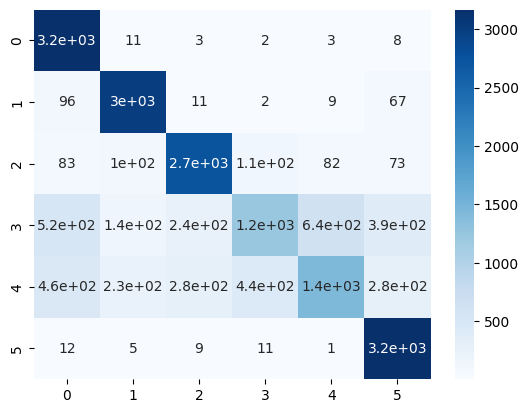

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm,cmap="Blues",annot=True)

# SVM

In [32]:
# Model
from sklearn.svm import SVC
svm_model_linear = SVC(kernel= 'linear', C = 1).fit(X_train, y_train)
svm_predictions  = svm_model_linear.predict(X_test)

In [33]:
example = np.zeros(100)
example = ["Kat is an absolutely disgusting human being"]
example = vectoriser.transform(example)
example

<1x489677 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [34]:
svm_model_linear.predict(example)

array([2])

In [35]:
accuracy = svm_model_linear.score(X_test, y_test)
print(accuracy)

0.8517487658859364


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = svm_model_linear.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3195
           1       0.97      0.99      0.98      3181
           2       0.91      0.88      0.90      3176
           3       0.66      0.60      0.62      3169
           4       0.65      0.69      0.67      3123
           5       0.96      0.97      0.97      3198

    accuracy                           0.85     19042
   macro avg       0.85      0.85      0.85     19042
weighted avg       0.85      0.85      0.85     19042



In [37]:
with open('svm.pkl', 'wb') as file:
    pickle.dump(svm_model_linear, file)

<Axes: >

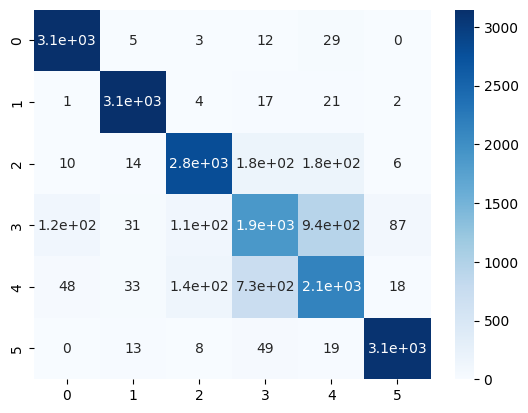

In [38]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,cmap="Blues",annot=True)

**Random Forest**

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
rf_pred = rf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3195
           1       0.98      0.98      0.98      3181
           2       0.92      0.82      0.87      3176
           3       0.60      0.55      0.58      3169
           4       0.57      0.69      0.62      3123
           5       0.97      0.96      0.96      3198

    accuracy                           0.83     19042
   macro avg       0.84      0.83      0.83     19042
weighted avg       0.84      0.83      0.83     19042



In [41]:
y_test

49043    3
88438    1
15404    2
70333    5
28238    4
        ..
57016    2
79660    0
27424    4
81808    0
35011    0
Name: cyberbullying_type, Length: 19042, dtype: int64

In [42]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,rf_pred))

0.8299023211847495


In [43]:
with open('randomforests.pkl', 'wb') as file:
    pickle.dump(rf, file)

<Axes: >

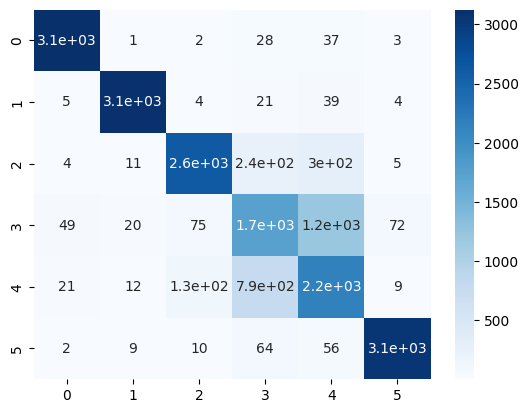

In [44]:
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm,cmap="Blues",annot=True)

# DL ALGORITHMS
* BERT
* LSTM
* Bi-LSTM

# BERT-CNN Model

In [45]:
# from transformers import AutoTokenizer, TFBertModel
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

**Test train split**

In [46]:
# X = df['tweet_text'].values
# y = df['cyberbullying_type'].values
# seed_value = 300
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [47]:
# X_train

In [48]:
# len(X)

In [49]:
# len(y)

**Tokenisation**

In [50]:
# x_train = tokenizer(
#     text = X_train.tolist(),
#     add_special_tokens = True,
#     max_length = 100,
#     truncation = True,
#     padding = True,
#     return_tensors = 'tf',
#     return_token_type_ids = False,
#     return_attention_mask = True,
#     verbose = True
# )

In [51]:
# x_train['input_ids']

In [52]:
# x_train['attention_mask']

In [53]:
# x_test = tokenizer(
#     text = X_test.tolist(),
#     add_special_tokens = True,
#     max_length = 100,
#     truncation = True,
#     padding = True,
#     return_tensors = 'tf',
#     return_token_type_ids = False,
#     return_attention_mask = True,
#     verbose = True
# )

In [54]:
# x_test['input_ids']

In [55]:
# x_test['attention_mask']

In [56]:
# len(x_train['input_ids'])

In [57]:
# len(y_train)

**CNN layers**

In [58]:
# max_len = 100


# input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
# input_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

# # 0 is the last hidden state, 1 means pooler_output
# # We need only the hidden state, so that we can add more layers and fine-tune the model.
# # We'll use functional API

# embeddings = bert(input_ids, attention_mask=input_mask)[0]
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# out = Dense(128, activation='relu')(out)
# out = tf.keras.layers.Dropout(0.1)(out)
# out = Dense(32, activation='relu')(out)

# op = Dense(6, activation='sigmoid')(out)

# model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=op)
# model.layers[2].trainable = True

In [59]:
# # Bert model requires a specific learning rate as stated in the huggingface website
# from tensorflow.keras.optimizers.legacy import Adam
# optimizer = Adam(
#     learning_rate=5e-05,
#     epsilon=1e-08,
#     decay=0.01,
#     clipnorm=1.0
# )

# loss = CategoricalCrossentropy(from_logits=True)
# metric = CategoricalAccuracy('balanced_accuracy')

# model.compile(
#     optimizer=optimizer,
#     loss=loss,
#     metrics=metric)

# model.summary()

In [60]:
# bert_train = model.fit(

#     x={'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
#     y=to_categorical(y_train),
#     validation_data=(
#         {'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']},to_categorical(y_train)
#     ),
#     epochs=1,
#     batch_size=32
# )

In [61]:
# pred_raw = model.predict({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})

# LSTM

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'],df['cyberbullying_type'], test_size=0.2, random_state=42)

In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.regularizers import l1, l2
lstmtokenizer = Tokenizer()
lstmtokenizer.fit_on_texts(df['tweet_text'])

In [91]:
X_train_sequences = lstmtokenizer.texts_to_sequences(X_train)
X_test_sequences  = lstmtokenizer.texts_to_sequences(X_test)

In [92]:
max_length     = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded  = pad_sequences(X_test_sequences , maxlen=max_length, padding='post')

In [93]:
# # Build the LSTM model
# embedding_dim = 100
# num_classes   = 6

# model2 = Sequential([
#     Embedding(input_dim=len(lstmtokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length),
#     LSTM(units=100),
#     Dense(units=num_classes, activation='softmax')
# ])

# model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [94]:
# Build the LSTM model
embedding_dim = 100
num_classes   = 6

model2 = Sequential([
    Embedding(input_dim=len(lstmtokenizer.word_index) + 1, output_dim=embedding_dim),
    LSTM(units=100),
    Dense(units=num_classes, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [95]:
# Train the model
lstm_history = model2.fit(X_train_padded, y_train, epochs=25, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 87s 36ms/step - accuracy: 0.6520 - loss: 0.7716 - val_accuracy: 0.8103 - val_loss: 0.4203
Epoch 2/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 87s 36ms/step - accuracy: 0.8596 - loss: 0.3417 - val_accuracy: 0.8530 - val_loss: 0.3774
Epoch 3/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9137 - loss: 0.2261 - val_accuracy: 0.8565 - val_loss: 0.3769
Epoch 4/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step - accuracy: 0.9331 - loss: 0.1632 - val_accuracy: 0.8537 - val_loss: 0.4146
Epoch 5/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9429 - loss: 0.1286 - val_accuracy: 0.8536 - val_loss: 0.4667
Epoch 6/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - accuracy: 0.9458 - loss: 0.1120 - val_accuracy: 0.8496 - val_loss: 0.5269
Epoch 7/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.9516 - loss: 0.0950 - val_accuracy: 0.8510 - val_loss: 0.5409
Epoch 8/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - accuracy: 0.9544

In [96]:
y_pred_probs = model2.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred))

596/596 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3257
           1       0.97      0.97      0.97      3175
           2       0.90      0.84      0.87      3162
           3       0.63      0.58      0.60      3096
           4       0.61      0.69      0.64      3139
           5       0.96      0.96      0.96      3213

    accuracy                           0.84     19042
   macro avg       0.84      0.84      0.84     19042
weighted avg       0.84      0.84      0.84     19042



In [97]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print(accuracy_score(y_test,y_pred))

0.8393025942653083


<Axes: >

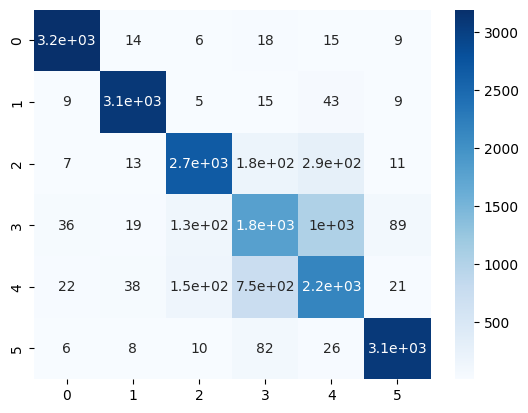

In [98]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,cmap="Blues",annot=True)

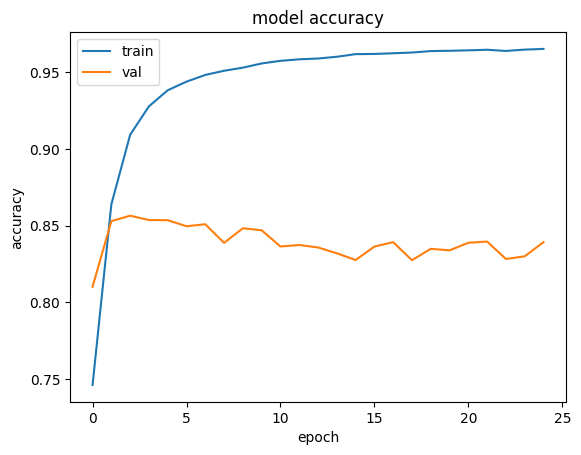

In [99]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Bi-LSTM

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'],df['cyberbullying_type'], test_size=0.2, random_state=42)

In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.regularizers import l1, l2
lstmtokenizer = Tokenizer()
lstmtokenizer.fit_on_texts(df['tweet_text'])

In [102]:
X_train_sequences = lstmtokenizer.texts_to_sequences(X_train)
X_test_sequences  = lstmtokenizer.texts_to_sequences(X_test)

In [103]:
max_length     = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded  = pad_sequences(X_test_sequences , maxlen=max_length, padding='post')

In [104]:
# from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
# # Build the LSTM model
# embedding_dim = 100
# num_classes   = 6

# model3 = Sequential([
#     Embedding(input_dim=len(lstmtokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length),
#     Bidirectional(LSTM(units=100)),
#     Dense(units=num_classes, activation='softmax')
# ])

# model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [105]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
# Build the LSTM model
embedding_dim = 100
num_classes   = 6

model3 = Sequential([
    Embedding(input_dim=len(lstmtokenizer.word_index) + 1, output_dim=embedding_dim),
    Bidirectional(LSTM(units=100)),
    Dense(units=num_classes, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [106]:
# Train the model
bilstm_history = model3.fit(X_train_padded, y_train, epochs=25, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 96s 39ms/step - accuracy: 0.7326 - loss: 0.6363 - val_accuracy: 0.8544 - val_loss: 0.3626
Epoch 2/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - accuracy: 0.8996 - loss: 0.2589 - val_accuracy: 0.8564 - val_loss: 0.3602
Epoch 3/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - accuracy: 0.9269 - loss: 0.1791 - val_accuracy: 0.8563 - val_loss: 0.3753
Epoch 4/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.9402 - loss: 0.1351 - val_accuracy: 0.8561 - val_loss: 0.4262
Epoch 5/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 100s 42ms/step - accuracy: 0.9465 - loss: 0.1111 - val_accuracy: 0.8517 - val_loss: 0.4772
Epoch 6/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9507 - loss: 0.0982 - val_accuracy: 0.8500 - val_loss: 0.5501
Epoch 7/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 93s 39ms/step - accuracy: 0.9566 - loss: 0.0829 - val_accuracy: 0.8482 - val_loss: 0.6141
Epoch 8/25
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 142s 39ms/step - accuracy: 0.957

In [107]:
y_pred_probs = model3.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred))

596/596 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3257
           1       0.96      0.98      0.97      3175
           2       0.89      0.85      0.87      3162
           3       0.62      0.59      0.60      3096
           4       0.61      0.64      0.63      3139
           5       0.95      0.96      0.96      3213

    accuracy                           0.84     19042
   macro avg       0.83      0.83      0.83     19042
weighted avg       0.84      0.84      0.84     19042



In [108]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print(accuracy_score(y_test,y_pred))

0.8365192731855897


<Axes: >

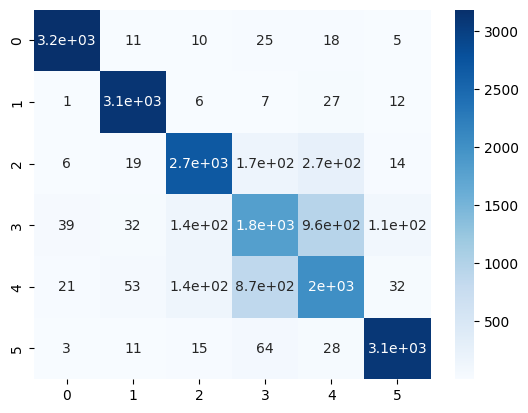

In [109]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,cmap="Blues",annot=True)

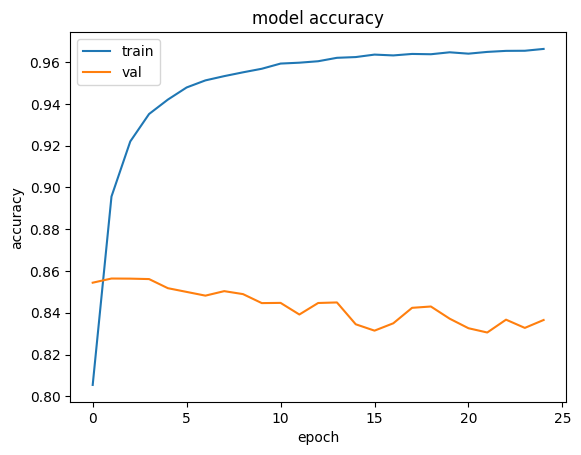

In [110]:
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()